In [1]:
from qiskit.quantum_info import SparsePauliOp
import matplotlib.pyplot as plt
import numpy as np
 
#!pip install pyscf==2.4.0
from pyscf import ao2mo, gto, mcscf, scf
 
 
def cholesky(V, eps):
    # see https://arxiv.org/pdf/1711.02242.pdf section B2
    # see https://arxiv.org/abs/1808.02625
    # see https://arxiv.org/abs/2104.08957
    no = V.shape[0]
    chmax, ng = 20 * no, 0
    W = V.reshape(no**2, no**2)
    L = np.zeros((no**2, chmax))
    Dmax = np.diagonal(W).copy()
    nu_max = np.argmax(Dmax)
    vmax = Dmax[nu_max]
    while vmax > eps:
        L[:, ng] = W[:, nu_max]
        if ng > 0:
            L[:, ng] -= np.dot(L[:, 0:ng], (L.T)[0:ng, nu_max])
        L[:, ng] /= np.sqrt(vmax)
        Dmax[: no**2] -= L[: no**2, ng] ** 2
        ng += 1
        nu_max = np.argmax(Dmax)
        vmax = Dmax[nu_max]
    L = L[:, :ng].reshape((no, no, ng))
    print(
        "accuracy of Cholesky decomposition ",
        np.abs(np.einsum("prg,qsg->prqs", L, L) - V).max(),
    )
    return L, ng
 
 
def identity(n):
    return SparsePauliOp.from_list([("I" * n, 1)])
 
 
def creators_destructors(n, mapping="jordan_wigner"):
    c_list = []
    if mapping == "jordan_wigner":
        for p in range(n):
            if p == 0:
                ell, r = "I" * (n - 1), ""
            elif p == n - 1:
                ell, r = "", "Z" * (n - 1)
            else:
                ell, r = "I" * (n - p - 1), "Z" * p
            cp = SparsePauliOp.from_list([(ell + "X" + r, 0.5), (ell + "Y" + r, -0.5j)])
            c_list.append(cp)
    else:
        raise ValueError("Unsupported mapping.")
    d_list = [cp.adjoint() for cp in c_list]
    return c_list, d_list

In [33]:
def ham_terms(x: float):
    distance = x
    a = distance / 2
    mol = gto.Mole()
    mol.build(
        verbose=0,
        atom=[
            ["H", (0, 0, -a)],
            ["H", (0, 0, a)],
        ],
        basis="cc-pvtz", #sto-6g
        spin=0, #mol.spin = 2S = Nalpha - Nbeta, not 2S+1
        charge=0,
        symmetry="Dooh",
    )
 
    # mf = scf.RHF(mol)
    # mx = mcscf.CASCI(mf, ncas=2, nelecas=(1, 1))
    # mx.kernel()
 
    mf = scf.RHF(mol)
    mf.kernel()
    if not mf.converged:
        raise RuntimeError(f"SCF did not converge for distance {x}")
 
    mx = mcscf.CASCI(mf, ncas=2, nelecas=(1, 1))
    casci_energy = mx.kernel()
    if casci_energy is None:
        raise RuntimeError(f"CASCI failed for distance {x}")
 
    # Other variables that might come in handy:
    # active_space = range(mol.nelectron // 2 - 1, mol.nelectron // 2 + 1)
    #    E1 = mf.kernel()
    # mo = mx.sort_mo(active_space, base=0)
    #    E2 = mx.kernel(mo)[:2]
 
    h1e, ecore = mx.get_h1eff()
    h2e = ao2mo.restore(1, mx.get_h2eff(), mx.ncas)
    return ecore, h1e, h2e

In [34]:
def build_hamiltonian(distx: float) -> SparsePauliOp:
    ecore = ham_terms(distx)[0]
    h1e = ham_terms(distx)[1]
    h2e = ham_terms(distx)[2]
 
    ncas, _ = h1e.shape
 
    C, D = creators_destructors(2 * ncas, mapping="jordan_wigner")
    Exc = []
    for p in range(ncas):
        Excp = [C[p] @ D[p] + C[ncas + p] @ D[ncas + p]]
        for r in range(p + 1, ncas):
            Excp.append(
                C[p] @ D[r]
                + C[ncas + p] @ D[ncas + r]
                + C[r] @ D[p]
                + C[ncas + r] @ D[ncas + p]
            )
        Exc.append(Excp)
 
    # low-rank decomposition of the Hamiltonian
    Lop, ng = cholesky(h2e, 1e-6)
    t1e = h1e - 0.5 * np.einsum("pxxr->pr", h2e)
 
    H = ecore * identity(2 * ncas)
    # one-body term
    for p in range(ncas):
        for r in range(p, ncas):
            H += t1e[p, r] * Exc[p][r - p]
    # two-body term
    for g in range(ng):
        Lg = 0 * identity(2 * ncas)
        for p in range(ncas):
            for r in range(p, ncas):
                Lg += Lop[p, r, g] * Exc[p][r - p]
        H += 0.5 * Lg @ Lg
 
    return H.chop().simplify()

In [35]:
# General imports
 
# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import efficient_su2
from qiskit.quantum_info import SparsePauliOp
 
# SciPy minimizer routine
from scipy.optimize import minimize
 
# Plotting functions
 
# Qiskit Runtime tools
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()

In [36]:
def cost_func(params, ansatz, H, estimator):
    pub = (ansatz, [H], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    return energy
 
 
# def cost_func_sim(params, ansatz, H, estimator):
#    energy = estimator.run(ansatz, H, parameter_values=params).result().values[0]
#    return energy

In [19]:
# Here, we select the least busy backend available:
backend = service.least_busy(operational=True, simulator=False)
print(backend)
# Or to select a specific real backend use the line below, and substitute 'ibm_strasbourg' for your chosen device.
# backend = service.get_backend('ibm_strasbourg')

<IBMBackend('ibm_fez')>


In [20]:
# To run on a simulator:
# -----------
from qiskit_aer import AerSimulator
 
backend_sim = AerSimulator.from_backend(backend)

In [37]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
    ConstrainedReschedule,
)
from qiskit.circuit.library import XGate
 
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target,
        ),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)

In [40]:
from qiskit.primitives import BackendEstimatorV2
 
estimator = BackendEstimatorV2(backend=backend_sim)
 
distances_sim = np.arange(0.3, 5, 0.1)
vqe_energies_sim = []
vqe_elec_energies_sim = []
 
for dist in distances_sim:
    xx = dist
 
    # Random initial state and efficient_su2 ansatz
    H = build_hamiltonian(xx)
    ansatz = efficient_su2(H.num_qubits)
    ansatz_isa = pm.run(ansatz)
    x0 = 2 * np.pi * np.random.random(ansatz_isa.num_parameters)
    H_isa = H.apply_layout(ansatz_isa.layout)
    nuclear_repulsion = ham_terms(xx)[0]
 
    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, H_isa, estimator),
        method="cobyla",
        options={"maxiter": 5, "disp": True},
    )
 
    # Note this returns the total energy, and we are often interested in the electronic energy
    tot_energy = getattr(res, "fun")
    electron_energy = getattr(res, "fun") - nuclear_repulsion
    print(electron_energy)
    vqe_energies_sim.append(tot_energy)
    vqe_elec_energies_sim.append(electron_energy)
 
    # Print all results
    print(res)
 
print("All energies have been calculated")

accuracy of Cholesky decomposition  4.252107037162496e-14
-1.8201413055312192
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =    5   F =-5.621727E-02    MAXCV = 0.000000E+00
   X = 5.747883E+00   2.992642E+00   3.895212E+00   1.385353E+00   4.134413E+00
       1.610970E+00   9.561115E-01   3.597154E+00   6.271455E+00   5.457788E-01
       8.506236E-01   2.780563E+00   4.337577E+00   4.666662E+00   1.112522E+00
       8.336749E-01   2.315391E+00   5.968338E+00   9.145794E-01   5.554904E+00
       2.867327E+00   5.311924E+00   1.956133E+00   1.267842E+00   5.891118E+00
       3.542237E+00   3.170597E+00   2.527353E+00   6.018827E+00   3.796585E+00
       2.756896E+00   1.166028E+00

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -0.05621726913121905
       x: [ 5.748e+00  2.993e+00 ...  2.757e+00  1.166e+00]
    nfev: 5
   maxcv: 0.0
accuracy of Cholesky decomposition  1.465057186457828e-1

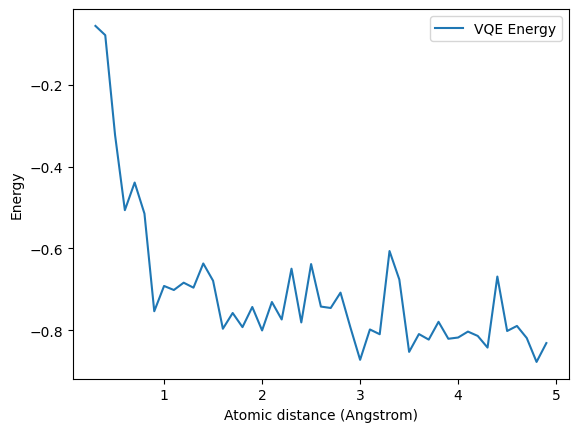

In [41]:
# Here we can plot the results from this simulation.
plt.plot(distances_sim, vqe_energies_sim, label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()